<a href="https://colab.research.google.com/github/cincysam6/Field_Control_Model/blob/main/Field_Control_Functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Magic
# %matplotlib inline

# Utility Libraries
from datetime import datetime
import pytz
from google.colab import files
from scipy.ndimage import gaussian_filter

# HTML
from IPython.display import HTML

# Computation Libraries
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import multivariate_normal, gamma
from scipy.spatial.distance import pdist, squareform

# Plotting libraries
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from matplotlib.patches import Rectangle, Arrow



# Graph Libraries
import networkx as nx

I Import a single play to test this out. Here we have play_id 2617 and gameId 2022092504 from the 2025 Big Data Bowl Competition.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/BDB_Data/pres_example_play.csv')
df.head()

,Unnamed: 0,gameId,playId,nflId,displayName,frameId,frameType,time,jerseyNumber,team,...,is_off,position,pff_defensiveCoverageAssignment,pff_primaryDefensiveCoverageMatchupNflId,pff_secondaryDefensiveCoverageMatchupNflId,y_norm,x_norm,std_x,std_y,player_tags
0,1,2022092504,2617,38632.0,Kirk Cousins,1,BEFORE_SNAP,2022-09-25 19:03:06.2,8.0,MIN,...,1.0,QB,NaN,NaN,NaN,29.503333,74,-5.87,1.84,off
1,2,2022092504,2617,38632.0,Kirk Cousins,2,BEFORE_SNAP,2022-09-25 19:03:06.3,8.0,MIN,...,1.0,QB,NaN,NaN,NaN,29.503333,74,-5.86,1.83,off
2,3,2022092504,2617,38632.0,Kirk Cousins,3,BEFORE_SNAP,2022-09-25 19:03:06.4,8.0,MIN,...,1.0,QB,NaN,NaN,NaN,29.503333,74,-5.86,1.83,off
3,4,2022092504,2617,38632.0,Kirk Cousins,4,BEFORE_SNAP,2022-09-25 19:03:06.5,8.0,MIN,...,1.0,QB,NaN,NaN,NaN,29.503333,74,-5.85,1.82,off
4,5,2022092504,2617,38632.0,Kirk Cousins,5,BEFORE_SNAP,2022-09-25 19:03:06.6,8.0,MIN,...,1.0,QB,NaN,NaN,NaN,29.503333,74,-5.83,1.81,off


In [ ]:
#df = pd.read_parquet('/content/drive/MyDrive/BDB_Data/motion_df_for_pitch_control.parquet')


# Filter the DataFrame
filtered_df = df[(df['gameId'] == 2022092504) & (df['playId'] == 2617)]

# Display the filtered DataFrame
print(filtered_df.head())


   Unnamed: 0      gameId  playId    nflId   displayName  frameId  \
0           1  2022092504    2617  38632.0  Kirk Cousins        1   
1           2  2022092504    2617  38632.0  Kirk Cousins        2   
2           3  2022092504    2617  38632.0  Kirk Cousins        3   
3           4  2022092504    2617  38632.0  Kirk Cousins        4   
4           5  2022092504    2617  38632.0  Kirk Cousins        5   

     frameType                   time  jerseyNumber team  ... is_off  \
0  BEFORE_SNAP  2022-09-25 19:03:06.2           8.0  MIN  ...    1.0   
1  BEFORE_SNAP  2022-09-25 19:03:06.3           8.0  MIN  ...    1.0   
2  BEFORE_SNAP  2022-09-25 19:03:06.4           8.0  MIN  ...    1.0   
3  BEFORE_SNAP  2022-09-25 19:03:06.5           8.0  MIN  ...    1.0   
4  BEFORE_SNAP  2022-09-25 19:03:06.6           8.0  MIN  ...    1.0   

   position  pff_defensiveCoverageAssignment  \
0        QB                              NaN   
1        QB                              NaN   
2       

In [ ]:
### Selecting a single player ID to test this out
one_player = [40488.0]

In [ ]:

# Function to compute distance from the football for a given frame
def compute_distances_by_frame(frame_data):
    # Isolate the football's position within the frame
    football_row = frame_data[frame_data['displayName'] == 'football']
    if football_row.empty:
        # If no football is present in the frame, return NaN for distances
        frame_data['dist_from_football'] = np.nan
    else:
        football_x = football_row['x'].values[0]
        football_y = football_row['y'].values[0]
        # Compute the distance for all players in the frame
        frame_data['dist_from_football'] = np.sqrt((frame_data['x'] - football_x) ** 2 +
                                                   (frame_data['y'] - football_y) ** 2)
    return frame_data

# Apply the function for each frameId group
df = df.groupby('frameId').apply(compute_distances_by_frame)

# Reset the index if needed
df.reset_index(drop=True, inplace=True)

# Verify results
print(df[['frameId', 'displayName', 'dist_from_football']])

      frameId         displayName  dist_from_football
0           1        Kirk Cousins            6.201815
1           1        Adam Thielen            6.730499
2           1      Charles Harris            2.227667
3           1       Alex Anzalone            3.314362
4           1        Johnny Mundt            5.450616
...       ...                 ...                 ...
4135      180  Christian Darrisaw           20.413538
4136      180        Alim McNeill           24.373954
4137      180           Ed Ingram           22.974850
4138      180   Malcolm Rodriguez            8.990200
4139      180            football            0.000000

[4140 rows x 3 columns]


/tmp/ipython-input-525440378.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('frameId').apply(compute_distances_by_frame)


In [ ]:
class PlayerInfluenceModelTunable:
    """
    Same core logic you’re using now, but with tunable knobs exposed.
    Orientation: uses your double-corrected heading plus a global bias.
    """

    def __init__(
        self,
        grid_x_res=200,
        grid_y_res=100,
        field_x_max=120,
        field_y_max=53.3,
        # Orientation
        orientation_bias_deg=90.0,      # If orientations needs to be correct. Keep this set to 90 using my data.
        # Gaussian controls
        gaussian_scale_factor=0.7,       # scales the Gaussian ellipse (bigger -> wider/longer)
        # Gamma controls
        alpha_gamma=11,                  # gamma shape (higher = peakier/narrower)
        beta_min=1.0, beta_max=20.0,     # gamma scale bounds (used in speed-based scaling)
        gamma_midpoint=15.0,             # speed where gamma scale changes most
        gamma_scale_factor=0.8,          # multiplies the gamma scale (bigger -> longer reach)
        max_forward_distance=20.0,       # yards before extra forward decay kicks in
        forward_decay_factor=1.0,        # >1 = slower fade after cap; <1 = faster
        # Angular cone
        angle_limit_min=15.0,            # narrowest cone at high speed
        angle_limit_max=45.0,            # widest cone at low speed
        angle_decay_factor=2.0,          # how fast cone narrows with speed
        # Mixture weights
        w_gaussian_min=0.2,              # minimum Gaussian weight (at high speed)
        w_gaussian_max=1.0,              # maximum Gaussian weight (at low speed)
        gaussian_midpoint=4.0,           # speed where Gaussian weight turns down
        gaussian_steepness=2.0           # steepness of the weight transition
    ):
        # Grid/field
        self.grid_x_res = grid_x_res
        self.grid_y_res = grid_y_res
        self.field_x_max = field_x_max
        self.field_y_max = field_y_max
        self.x_vals = np.linspace(0, field_x_max, grid_x_res)
        self.y_vals = np.linspace(0, field_y_max, grid_y_res)
        self.X, self.Y = np.meshgrid(self.x_vals, self.y_vals)
        self.grid = (self.X, self.Y)

        # Knobs
        self.orientation_bias_deg = orientation_bias_deg
        self.gaussian_scale_factor = gaussian_scale_factor
        self.alpha_gamma = alpha_gamma
        self.beta_min, self.beta_max = beta_min, beta_max
        self.gamma_midpoint = gamma_midpoint
        self.gamma_scale_factor = gamma_scale_factor
        self.max_forward_distance = max_forward_distance
        self.forward_decay_factor = forward_decay_factor
        self.angle_limit_min = angle_limit_min
        self.angle_limit_max = angle_limit_max
        self.angle_decay_factor = angle_decay_factor
        self.w_gaussian_min = w_gaussian_min
        self.w_gaussian_max = w_gaussian_max
        self.gaussian_midpoint = gaussian_midpoint
        self.gaussian_steepness = gaussian_steepness

    # -------- angles ----------
    @staticmethod
    def _norm(a): return (a + 360) % 360
    def corrected_orientation(self, deg): return self._norm(90 - deg)
    def double_corrected_orientation(self, deg):
        return self.corrected_orientation(self.corrected_orientation(deg))
    def _theta(self, deg):
        return np.radians(self._norm(self.double_corrected_orientation(deg) + self.orientation_bias_deg))

    # -------- weights ----------
    def dynamic_weights(self, speed):
        g = self.w_gaussian_min + (self.w_gaussian_max - self.w_gaussian_min) / \
            (1 + np.exp(self.gaussian_steepness * (speed - self.gaussian_midpoint)))
        return g, 1 - g

    # -------- gaussian ----------
    @staticmethod
    def _radius_influence(d):
        return 1 + (3 / (18 ** 2)) * (d ** 2) if d <= 18 else 3

    def _sigma(self, theta, speed, dist_from_ball, scale_factor=0.7, MAX_S=11.3):
        R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        speed_ratio = (speed ** 2) / (MAX_S ** 2)
        base = self._radius_influence(dist_from_ball)
        sx = (base + base * speed_ratio) * self.gaussian_scale_factor
        sy = max((base - base * speed_ratio) * self.gaussian_scale_factor, sx * 0.5)
        S = np.array([[sx, 0], [0, sy]])
        return R @ (S**2) @ R.T

    @staticmethod
    def _mu(pos, vel):  # matches your 0.5 * velocity push
        return np.array(pos) + 0.5 * vel

    def compute_offset(self, pos, dir_deg, speed):
        # keep your simple “mode at player” approach
        beta = self.beta_min + (self.beta_max - self.beta_min) / (1 + np.exp(1.0 * (speed - 1.0)))
        mode = (8 - 1) / beta  # alpha=8 in your offset
        th = self._theta(dir_deg)
        return (pos[0] - mode * np.cos(th), pos[1] - mode * np.sin(th))

    def base_distribution(self, pos, pos_off, dir_deg, speed, sigma_gaussian, alpha_gamma, dist_from_ball):
        X, Y = self.grid
        x_off, y_off = pos_off
        th = self._theta(dir_deg)

        # velocity
        vel = np.array([np.cos(th) * speed, np.sin(th) * speed])

        # cone width vs speed
        ang_lim = self.angle_limit_min + (self.angle_limit_max - self.angle_limit_min) * np.exp(-speed / self.angle_decay_factor)

        # gaussian
        cov = self._sigma(th, speed, dist_from_ball)
        mu = self._mu(pos, vel)
        cov += np.eye(2) * 1e-6
        G = multivariate_normal(mean=mu, cov=cov).pdf(np.dstack((X, Y)))
        G /= G.max() if G.max() > 0 else 1.0

        # gamma projected forward
        beta_dyn = self.beta_min + (self.beta_max - self.beta_min) * (speed / self.gamma_midpoint)
        beta_dyn = np.clip(beta_dyn, self.beta_min, self.beta_max)
        dx, dy = X - x_off, Y - y_off
        d_proj = dx * np.cos(th) + dy * np.sin(th)
        d_scaled = d_proj / max(speed * (1 + speed / 18), 1e-3)
        H = gamma.pdf(d_scaled, a=alpha_gamma, scale=1 / (beta_dyn * self.gamma_scale_factor))

        # forward fade after cap
        mask = d_proj > self.max_forward_distance
        if np.any(mask):
            fade = self.forward_decay_factor if self.forward_decay_factor > 0 else 1.0
            H[mask] *= np.exp(-((d_proj[mask] - self.max_forward_distance) ** 2) / (2 * (speed * fade) ** 2))

        # angular gate
        ang_to_pt = np.arctan2(dy, dx)
        ang_diff = np.abs((ang_to_pt - th + np.pi) % (2 * np.pi) - np.pi)
        H *= 1 / (1 + np.exp(10 * (ang_diff - np.radians(ang_lim))))
        H /= H.max() if H.max() > 0 else 1.0

        wG, wH = self.dynamic_weights(speed)
        return wG * G + wH * H

    def compute_influence(self, df, frame_id, player_ids=None):
        f = df[df['frameId'] == frame_id].copy()
        if player_ids is not None:
            # Ensure player_ids is a list for filtering
            if not isinstance(player_ids, (list, tuple)):
                player_ids = [player_ids]
            f = f[f['nflId'].isin(player_ids)].copy()

        f = f[f['displayName'] != 'football'].copy()
        rows = []
        for _, r in f.iterrows():
            pos = (r['x'], r['y']); dir_deg = r['dir']; spd = r['s']; dball = r['dist_from_football']
            pos_off = self.compute_offset(pos, dir_deg, spd)
            Z = self.base_distribution(pos, pos_off, dir_deg, spd, sigma_gaussian=5, alpha_gamma=self.alpha_gamma, dist_from_ball=dball)
            rows.append({**r.to_dict(), "density_grid": Z})
        return pd.DataFrame(rows)

In [ ]:
def diagnostic_plot(
    df,
    frame_id,
    player_ids=None,
    # Player speeds to plot — tuple/list of numbers OR ('actual',)
    speeds=(1, 5, 10),

    # Influence model settings
    grid_x_res=200,              # Number of X grid points (resolution in length direction)
    grid_y_res=100,              # Number of Y grid points (resolution in width direction)
    field_x_max=120,             # Field length in yards
    field_y_max=53.3,            # Field width in yards
    orientation_bias_deg=90.0,  # Global rotation correction (negative = rotate clockwise)

    # Gaussian parameters
    sigma_gaussian=5,            # Base Gaussian sigma (spread)
    gaussian_scale_factor=0.7,   # Scales the Gaussian ellipse
    #w_gaussian_min=0.2,          # Min Gaussian weight (at high speeds) # Duplicate argument
    w_gaussian_max=1.0,          # Max Gaussian weight (at low speeds)
    gaussian_midpoint=4.0,       # Speed where Gaussian weight starts to drop
    gaussian_steepness=2.0,      # Steepness of Gaussian weight dropoff

    # Gamma parameters
    alpha_gamma=11,              # Gamma shape parameter
    beta_min=1.0,                # Gamma scale min
    beta_max=20.0,               # Gamma scale max
    gamma_midpoint=15.0,         # Speed where Gamma scale changes most
    gamma_scale_factor=0.8,      # Scales the Gamma reach
    max_forward_distance=20,     # Max forward reach before decay
    forward_decay_factor=1.0,    # How quickly Gamma decays past max_forward_distance

    # Angular filtering
    angle_limit_min=15,          # Narrowest cone (high speeds)
    angle_limit_max=45,          # Widest cone (low speeds)
    angle_decay_factor=2.0,      # Controls how quickly cone narrows with speed

    # Mixture weights
    w_gaussian_min=0.2,              # minimum Gaussian weight (at high speed)
    #w_gaussian_max=1.0,              # maximum Gaussian weight (at low speed) # Duplicate argument
    #gaussian_midpoint=4.0,           # speed where Gaussian weight turns down # Duplicate argument
    #gaussian_steepness=2.0,          # steepness of the weight transition # Duplicate argument

    # Plot style
    contour_levels=20,           # Number of contour bands
    cmap='Reds',                 # Color map
    alpha=0.3,                   # Contour transparency
    arrow_scale=5,               # Arrow length scaling
    arrow_head_width=1,          # Arrow head width
    arrow_head_length=2,         # Arrow head length
    zoom_x_range=10,              # Horizontal zoom range around player (yards)
    ylim=(0, 53),                # Y-axis limits (tuple or None)
    grid_alpha=0.2,              # Field grid line transparency

    # Behavior
    show=True,                   # Show plot immediately
    return_fig=False             # Return matplotlib figure objects instead of showing
):
    """
    Diagnostic plot for Gaussian–Gamma player influence.

    You can tweak nearly every component of the shape:
    - Gaussian controls for spread and weight
    - Gamma controls for shape, reach, decay
    - Angular cone controls
    - Plot style controls
    - Rotation correction (orientation_bias_deg)
    """
    # Pass all model-related settings to PlayerInfluenceModel
    model = PlayerInfluenceModelTunable(
        grid_x_res=grid_x_res,
        grid_y_res=grid_y_res,
        field_x_max=field_x_max,
        field_y_max=field_y_max,
        orientation_bias_deg=orientation_bias_deg,
        gaussian_scale_factor=gaussian_scale_factor,
        alpha_gamma=alpha_gamma,
        beta_min=beta_min, beta_max=beta_max,
        gamma_midpoint=gamma_midpoint, gamma_scale_factor=gamma_scale_factor,
        max_forward_distance=max_forward_distance, forward_decay_factor=forward_decay_factor,
        angle_limit_min=angle_limit_min, angle_limit_max=angle_limit_max, angle_decay_factor=angle_decay_factor,
        w_gaussian_min=w_gaussian_min, w_gaussian_max=w_gaussian_max,
        gaussian_midpoint=gaussian_midpoint, gaussian_steepness=gaussian_steepness
    )

    influence_df = model.compute_influence(df, frame_id, player_ids)
    figs = []
    X, Y = model.grid

    for _, row in influence_df.iterrows():
        player_pos = (row['x'], row['y'])
        player_orientation_deg = row['dir'] # Changed 'direction' to 'dir'
        dist_from_football = row['dist_from_football']
        display_name = row.get('displayName', 'Player')

        # Determine which speeds to use
        use_actual = (isinstance(speeds, (list, tuple)) and len(speeds) == 1 and speeds[0] == 'actual') \
                     or speeds == ('actual',)
        speed_list = [row['s']] if use_actual else list(speeds) # Changed 'speed' to 's'

        for spd in speed_list:
            pos_offset = model.compute_offset(player_pos, player_orientation_deg, spd)
            Z = model.base_distribution(
                player_pos, pos_offset, player_orientation_deg, spd,
                sigma_gaussian=sigma_gaussian,
                alpha_gamma=alpha_gamma,
                dist_from_ball=dist_from_football
            )

            fig = plt.figure(figsize=(10, 7))
            plt.contourf(X, Y, Z, levels=contour_levels, cmap=cmap, alpha=alpha)
            plt.scatter(player_pos[0], player_pos[1], color='blue', edgecolor='black', s=100, zorder=5)

            theta = model._theta(player_orientation_deg)
            arrow_len = (spd / 11.3) * arrow_scale
            plt.arrow(
                player_pos[0], player_pos[1],
                arrow_len * np.cos(theta), arrow_len * np.sin(theta),
                head_width=arrow_head_width, head_length=arrow_head_length,
                fc='black', ec='black', zorder=6
            )

            title_speed = f"{spd} m/s" if not use_actual else f"{row['s']:.2f} m/s" # Changed 'speed' to 's'
            plt.title(f"{display_name} – Field Control (Gaussian–Gamma) at Speed={title_speed}")
            plt.xlabel('X Coordinate'); plt.ylabel('Y Coordinate')
            plt.grid(alpha=grid_alpha)

            plt.xlim(player_pos[0] - zoom_x_range, player_pos[0] + zoom_x_range)
            if ylim:
                plt.ylim(*ylim)

            if show:
                plt.show()
            figs.append(fig)

    return figs if return_fig else None

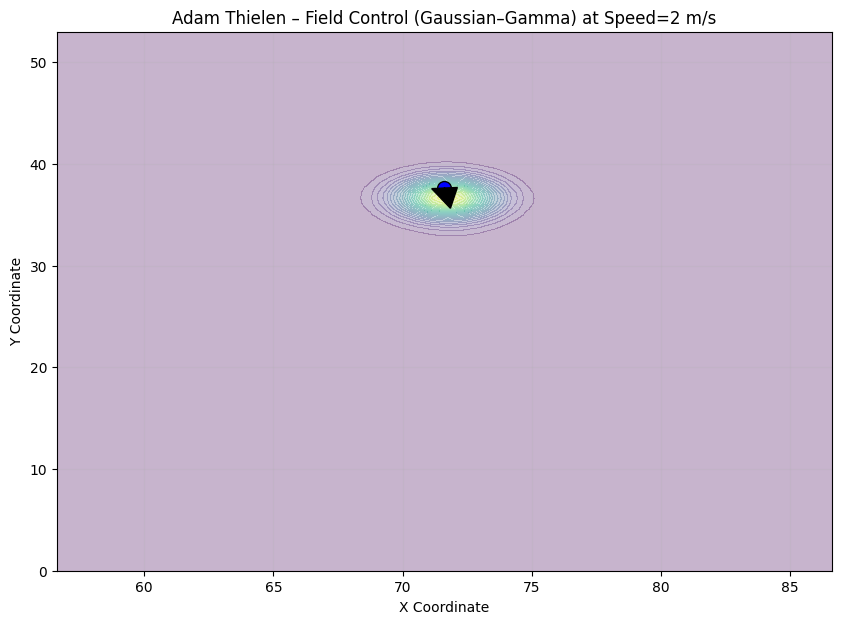

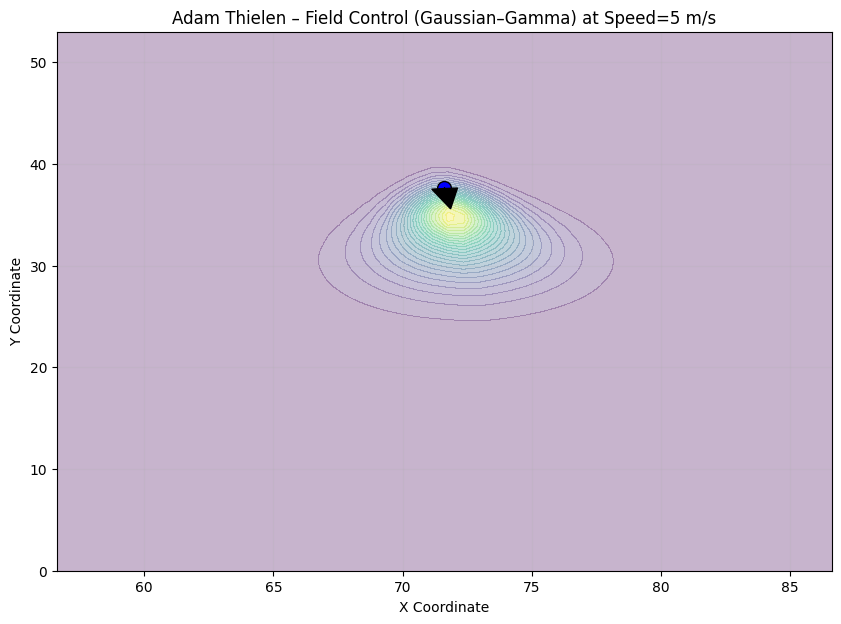

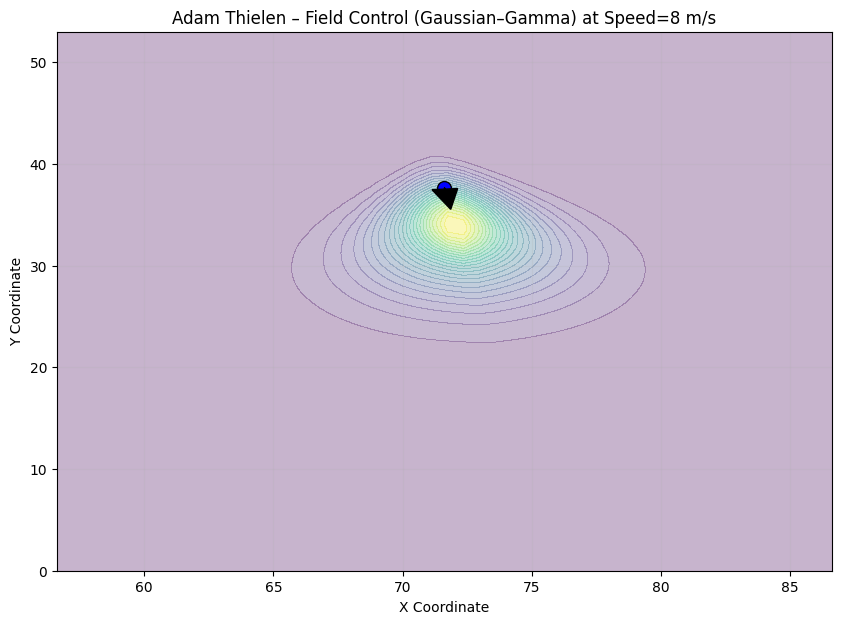

In [ ]:
diagnostic_plot(
    df,
    frame_id=100,
    player_ids=one_player,
    speeds=(2, 5, 8),
    orientation_bias_deg=90,
    sigma_gaussian=5,
    gaussian_scale_factor=0.8,
    alpha_gamma=9,
    max_forward_distance=25,
    forward_decay_factor=2.0,
    angle_limit_min=10,
    angle_limit_max=20,
    contour_levels=30,
    cmap='viridis',
    arrow_scale=.2,
    zoom_x_range=15
)

In [ ]:
def diagnostic_cheatsheet_tunable(
    df,
    frame_id,
    player_id,
    speed=5,
    # -------- baseline knobs (used for all panels unless overridden) --------
    orientation_bias_deg=90.0,   # rotate everything; -90° usually makes “downfield”
    gaussian_scale_factor=0.7,    # Gaussian ellipse size/elongation
    alpha_gamma=11,               # Gamma peakiness (higher = taller/narrower)
    beta_min=1.0, beta_max=20.0,  # Gamma scale bounds
    gamma_midpoint=15.0,          # Speed where Gamma scale changes most
    gamma_scale_factor=0.8,       # Gamma overall reach multiplier
    max_forward_distance=20.0,    # Forward reach limit before extra fade
    forward_decay_factor=1.0,     # >1 = slower fade after cap; <1 = faster
    angle_limit_min=15.0,         # narrowest cone (high speed)
    angle_limit_max=45.0,         # widest cone (low speed)
    angle_decay_factor=2.0,       # how fast cone narrows with speed
    w_gaussian_min=0.2,           # min Gaussian weight (at high speeds)
    w_gaussian_max=1.0,           # max Gaussian weight (at low speeds)
    gaussian_midpoint=4.0,        # speed where Gaussian weight turns down
    gaussian_steepness=2.0,       # steepness of weight transition
    # -------- plot styling --------
    cmap="Reds", alpha=0.30, contour_levels=18,
    zoom_x_range=12, ylim=(0, 53), grid_alpha=0.2
):
    """
    Builds a grid of small panels, each varying ONE knob from the baseline so you can
    see its effect. Also returns a list of per-panel parameters you can copy into your model.
    """

    panel_params = []  # <-- collect settings for each panel

    def render_panel(ax, title, **override):
        # Build a tunable model with baseline knobs, then apply per-panel overrides
        model = PlayerInfluenceModelTunable(
            orientation_bias_deg=orientation_bias_deg,
            gaussian_scale_factor=gaussian_scale_factor,
            alpha_gamma=alpha_gamma,
            beta_min=beta_min, beta_max=beta_max,
            gamma_midpoint=gamma_midpoint, gamma_scale_factor=gamma_scale_factor,
            max_forward_distance=max_forward_distance, forward_decay_factor=forward_decay_factor,
            angle_limit_min=angle_limit_min, angle_limit_max=angle_limit_max, angle_decay_factor=angle_decay_factor,
            w_gaussian_min=w_gaussian_min, w_gaussian_max=w_gaussian_max,
            gaussian_midpoint=gaussian_midpoint, gaussian_steepness=gaussian_steepness
        )
        # Apply overrides
        for k, v in override.items():
            setattr(model, k, v)

        # --- Record & print the parameters used for this panel
        params = {
            "orientation_bias_deg": model.orientation_bias_deg,
            "gaussian_scale_factor": model.gaussian_scale_factor,
            "alpha_gamma": model.alpha_gamma,
            "beta_min": model.beta_min,
            "beta_max": model.beta_max,
            "gamma_midpoint": model.gamma_midpoint,
            "gamma_scale_factor": model.gamma_scale_factor,
            "max_forward_distance": model.max_forward_distance,
            "forward_decay_factor": model.forward_decay_factor,
            "angle_limit_min": model.angle_limit_min,
            "angle_limit_max": model.angle_limit_max,
            "angle_decay_factor": model.angle_decay_factor,
            "w_gaussian_min": model.w_gaussian_min,
            "w_gaussian_max": model.w_gaussian_max,
            "gaussian_midpoint": model.gaussian_midpoint,
            "gaussian_steepness": model.gaussian_steepness,
            "speed": speed
        }
        panel_params.append({"title": title, "params": params})
        print(f"[{title}] {params}")

        # --- Render the panel
        row = df[(df["frameId"] == frame_id) & (df["nflId"].isin(np.atleast_1d(player_id)))].iloc[0]
        pos = (row["x"], row["y"])
        dir_deg = row["dir"]
        dist = row["dist_from_football"]

        pos_off = model.compute_offset(pos, dir_deg, speed)
        Z = model.base_distribution(
            pos, pos_off, dir_deg, speed,
            sigma_gaussian=5, alpha_gamma=model.alpha_gamma, dist_from_ball=dist
        )

        X, Y = model.grid
        ax.contourf(X, Y, Z, levels=contour_levels, cmap=cmap, alpha=alpha)
        ax.scatter(pos[0], pos[1], color="blue", edgecolor="black", s=45, zorder=5)

        th = model._theta(dir_deg)
        L = (speed / 11.3) * 5
        ax.arrow(pos[0], pos[1], L*np.cos(th), L*np.sin(th),
                 head_width=0.8, head_length=1.6, fc="black", ec="black", zorder=6)

        ax.set_title(title, fontsize=10)
        ax.set_xlim(pos[0]-zoom_x_range, pos[0]+zoom_x_range)
        if ylim: ax.set_ylim(*ylim)
        ax.grid(alpha=grid_alpha); ax.set_xticks([]); ax.set_yticks([])

    # Panels: (title, overrides) — tweak/add whatever you care about most
    panels = [
        ("Gaussian scale ↓", {"gaussian_scale_factor": max(0.3, gaussian_scale_factor*0.6)}),
        ("Gaussian scale ↑", {"gaussian_scale_factor": gaussian_scale_factor*1.4}),

        ("Gamma α ↓ (flatter)", {"alpha_gamma": max(4, int(alpha_gamma*0.7))}),
        ("Gamma α ↑ (peakier)", {"alpha_gamma": int(alpha_gamma*1.3)}),

        ("Gamma reach ↓", {"max_forward_distance": max(8, int(max_forward_distance*0.6))}),
        ("Gamma reach ↑", {"max_forward_distance": int(max_forward_distance*1.4)}),

        ("Gamma fade fast", {"forward_decay_factor": 0.6}),
        ("Gamma fade slow", {"forward_decay_factor": 2.0}),

        ("Cone narrow", {"angle_limit_min": min(angle_limit_max-5, angle_limit_min+12),
                         "angle_limit_max": max(angle_limit_min+5, angle_limit_max-12)}),
        ("Cone wide", {"angle_limit_min": max(0, angle_limit_min-12),
                       "angle_limit_max": min(85, angle_limit_max+12)}),

        ("More Gaussian", {"w_gaussian_min": min(0.6, w_gaussian_min+0.2)}),
        ("More Gamma",    {"w_gaussian_min": max(0.0, w_gaussian_min-0.2)}),
    ]

    cols = 4
    rows = int(np.ceil(len(panels)/cols))
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3.6*rows))
    axes = np.array(axes).reshape(-1)

    for ax, (title, overrides) in zip(axes, panels):
        render_panel(ax, title, **overrides)

    # Hide any leftover empty axes
    for i in range(len(panels), len(axes)):
        axes[i].axis("off")

    fig.suptitle(f"Influence Cheat Sheet • frame {frame_id} • player {player_id} • speed={speed} m/s",
                 fontsize=14)
    fig.tight_layout(rect=[0, 0.02, 1, 0.96])
    return fig, panel_params



[Gaussian scale ↓] {'orientation_bias_deg': 90.0, 'gaussian_scale_factor': 0.42, 'alpha_gamma': 11, 'beta_min': 1.0, 'beta_max': 20.0, 'gamma_midpoint': 15.0, 'gamma_scale_factor': 0.8, 'max_forward_distance': 20.0, 'forward_decay_factor': 1.0, 'angle_limit_min': 15.0, 'angle_limit_max': 45.0, 'angle_decay_factor': 2.0, 'w_gaussian_min': 0.2, 'w_gaussian_max': 1.0, 'gaussian_midpoint': 4.0, 'gaussian_steepness': 2.0, 'speed': 5}
[Gaussian scale ↑] {'orientation_bias_deg': 90.0, 'gaussian_scale_factor': 0.9799999999999999, 'alpha_gamma': 11, 'beta_min': 1.0, 'beta_max': 20.0, 'gamma_midpoint': 15.0, 'gamma_scale_factor': 0.8, 'max_forward_distance': 20.0, 'forward_decay_factor': 1.0, 'angle_limit_min': 15.0, 'angle_limit_max': 45.0, 'angle_decay_factor': 2.0, 'w_gaussian_min': 0.2, 'w_gaussian_max': 1.0, 'gaussian_midpoint': 4.0, 'gaussian_steepness': 2.0, 'speed': 5}
[Gamma α ↓ (flatter)] {'orientation_bias_deg': 90.0, 'gaussian_scale_factor': 0.7, 'alpha_gamma': 7, 'beta_min': 1.0, 'b

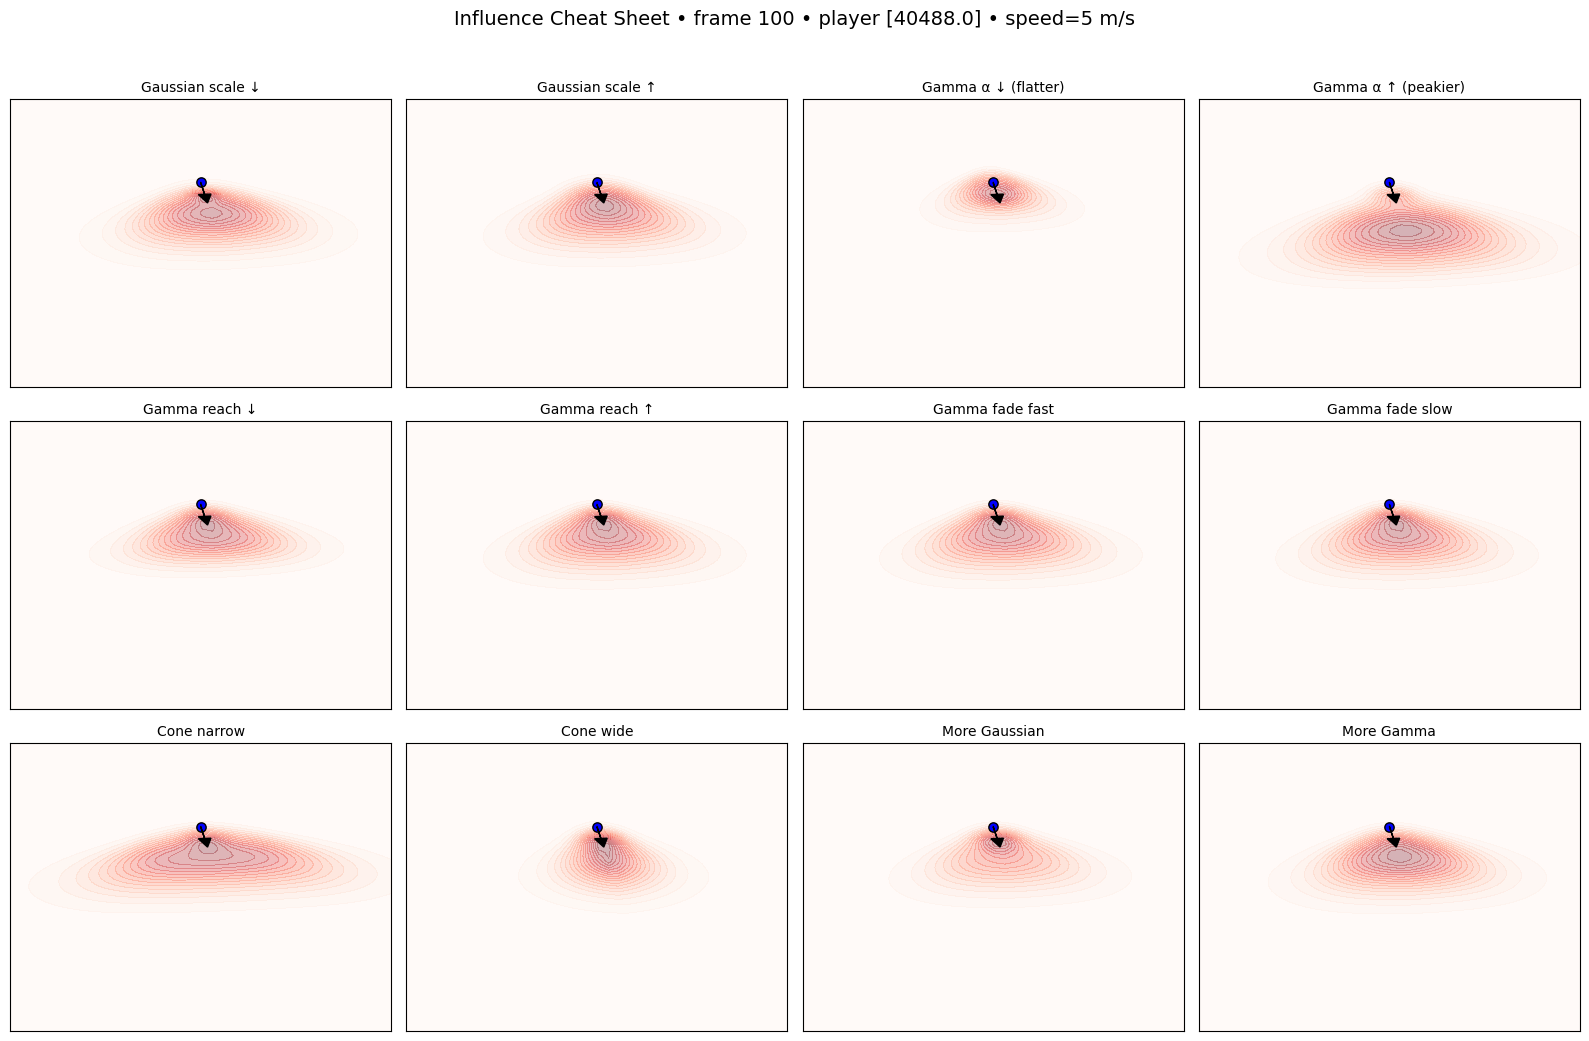

In [ ]:
fig, params = diagnostic_cheatsheet_tunable(df, frame_id=100, player_id=one_player, speed=5)

# Print the “winner” panel’s settings cleanly
best = next(p for p in params if p["title"] == "Gamma fade slow")  # for example
print("Best params:", best["params"])


In [ ]:
def compute_player_densities_dataframe(
    df,
    min_frame,
    max_frame,
    *,
    model_kwargs=None,          # e.g. {"orientation_bias_deg": -90.0, ...}
    sigma_gaussian=5,
    alpha_gamma=11,
    exclude_football=True
):
    """
    Compute Gaussian–Gamma densities for all players across [min_frame, max_frame]
    using PlayerInfluenceModelTunable. Stores the orientation bias used so plotting
    can automatically match it later.
    Returns:
      - all_player_df: one row per (frameId, nflId) with the 2D 'density' grid
      - (X, Y): the model's grid
    """
    if min_frame > max_frame:
        raise ValueError("min_frame must be less than or equal to max_frame.")

    model = PlayerInfluenceModelTunable(**(model_kwargs or {}))
    X, Y = model.grid

    df_range = df[(df["frameId"] >= min_frame) & (df["frameId"] <= max_frame)].copy()
    if exclude_football and "displayName" in df_range.columns:
        df_range = df_range[df_range["displayName"] != "football"]

    rows_out = []
    for frame_id in sorted(df_range["frameId"].unique()):
        frame_df = df_range[df_range["frameId"] == frame_id]
        if frame_df.empty:
            continue

        for _, r in frame_df.iterrows():
            try:
                pos = (r["x"], r["y"])
                dir_deg = r["dir"]
                spd = r["s"]
                dball = r.get("dist_from_football", 0.0)

                pos_off = model.compute_offset(pos, dir_deg, spd)
                Z = model.base_distribution(
                    pos, pos_off, dir_deg, spd,
                    sigma_gaussian=sigma_gaussian,
                    alpha_gamma=alpha_gamma,
                    dist_from_ball=dball
                )

                rows_out.append({
                    "frameId": frame_id,
                    "nflId": r["nflId"],
                    "displayName": r.get("displayName", None),
                    "jerseyNumber": r.get("jerseyNumber", None),
                    "x": pos[0],
                    "y": pos[1],
                    "speed": spd,
                    "direction": dir_deg,                   # raw tracking dir
                    "is_off": r.get("is_off", None),
                    "dist_from_football": dball,
                    "orientation_bias_deg": model.orientation_bias_deg,  # <-- store the bias used
                    "density": Z
                })
            except Exception as e:
                print(f"Error processing nflId={r.get('nflId')} in frame {frame_id}: {e}")

    all_player_df = pd.DataFrame(rows_out)
    return all_player_df, (X, Y)



In [ ]:
# 1) Compute densities (bias is saved into the dataframe)
all_player_df, grid = compute_player_densities_dataframe(
    df,
    min_frame=100,
    max_frame=110,
    model_kwargs={
        "orientation_bias_deg": 90.0,     # ← pick your bias ONCE here (e.g., -90.0 for “downfield”)
        "gaussian_scale_factor": 0.7,
        "alpha_gamma": 7,
        "max_forward_distance": 20.0,
        "forward_decay_factor": 1.2,
        "angle_limit_min": 3,
        "angle_limit_max": 57,
        "angle_decay_factor": 2.0,
        "w_gaussian_min": 0.2,
        "w_gaussian_max": 1.0,
        "gaussian_midpoint": 4.0,
        "gaussian_steepness": 2.0,
    },
    sigma_gaussian=5,
    alpha_gamma=11,
)


/tmp/ipython-input-4205020669.py:131: RuntimeWarning: divide by zero encountered in divide
  H[mask] *= np.exp(-((d_proj[mask] - self.max_forward_distance) ** 2) / (2 * (speed * fade) ** 2))


In [ ]:
def plot_player_densities_from_dataframe(
    player_df,
    grid,
    frame_id,
    *,
    orientation_bias_deg=90.0,     # fallback if a row doesn't have a stored bias
    contour_levels=20,
    contour_alpha=0.30,
    off_cmap="Reds",
    on_cmap="Blues",
    arrow_scale=2.0,
    arrow_head_width=0.375,
    arrow_head_length=0.75,
    xlim=None,
    ylim=None,
    grid_alpha=0.10,
    title="Individual Player Influence",
    show=True
):
    """
    Plot precomputed densities. Arrows are aligned to each row's stored
    orientation bias (used during density computation). If missing, uses
    `orientation_bias_deg` provided here as a fallback.
    """

    def _norm(a): return (a + 360) % 360
    def _corrected(deg): return _norm(90 - deg)
    def _double_corrected(deg): return _corrected(_corrected(deg))
    def _theta(dir_deg, bias_deg):  # radians
        return np.radians(_norm(_double_corrected(dir_deg) + bias_deg))

    X, Y = grid
    _MAX_FIELD_X, _MAX_FIELD_Y = 120, 53.3

    f = player_df[player_df["frameId"] == frame_id].copy()
    if f.empty:
        print(f"Warning: no players found for frameId={frame_id}")
        return

    aspect = _MAX_FIELD_Y / _MAX_FIELD_X
    fig, ax = plt.subplots(figsize=(20, 20 * aspect))

    for x in range(10, 120, 10):
        ax.axvline(x, color="k", linestyle="-", alpha=0.05)

    for _, row in f.iterrows():
        if str(row.get("displayName", "")).lower() == "football":
            continue

        # choose colors by offense/defense
        is_off = row.get("is_off", None)
        player_color = "blue" if is_off == 1 else "red"
        density_cmap = on_cmap if is_off == 1 else off_cmap

        # use per-row stored bias if present
        row_bias = row.get("orientation_bias_deg", orientation_bias_deg)

        Z = row["density"]
        Z_masked = np.where(Z > 0.01, Z, np.nan)
        ax.contourf(X, Y, Z_masked, cmap=density_cmap, levels=contour_levels, alpha=contour_alpha)

        x0, y0 = row["x"], row["y"]
        ax.scatter(x0, y0, color=player_color, s=200, edgecolor="black", zorder=5)

        jn = row.get("jerseyNumber", None)
        if jn is not None and not (isinstance(jn, float) and np.isnan(jn)):
            ax.text(x0, y0, f"{int(jn)}", fontsize=8, ha="center", color="white", zorder=6)

        name = row.get("displayName", None)
        if name:
            ax.text(x0, y0 - 1.5, str(name), fontsize=8, ha="center", color="black", zorder=6)

        dir_deg = row.get("direction", row.get("orientation", None))
        if dir_deg is not None:
            th = _theta(dir_deg, row_bias)
            spd = row.get("speed", 0.0)
            L = arrow_scale * (1.0 + min(max(spd, 0.0), 11.3) / 11.3)  # modest speed scaling
            ax.arrow(
                x0, y0,
                L * np.cos(th), L * np.sin(th),
                head_width=arrow_head_width, head_length=arrow_head_length,
                fc="black", ec="black", zorder=4
            )

    ax.set_title(f"{title} — Frame {frame_id}")
    ax.set_xlabel("X (yards)")
    ax.set_ylabel("Y (yards)")
    ax.grid(alpha=grid_alpha)

    ax.set_xlim(*xlim) if xlim else ax.set_xlim(0, _MAX_FIELD_X)
    ax.set_ylim(*ylim) if ylim else ax.set_ylim(0, _MAX_FIELD_Y)

    if show:
        plt.show()

    return fig, ax


In [ ]:
# 1. Compute densities for a range of frames
all_player_df, grid = compute_player_densities_dataframe(df, min_frame=100, max_frame=132)

# 2. Pick a frame to visualize
frame_to_plot = 120

/tmp/ipython-input-4205020669.py:131: RuntimeWarning: divide by zero encountered in divide
  H[mask] *= np.exp(-((d_proj[mask] - self.max_forward_distance) ** 2) / (2 * (speed * fade) ** 2))


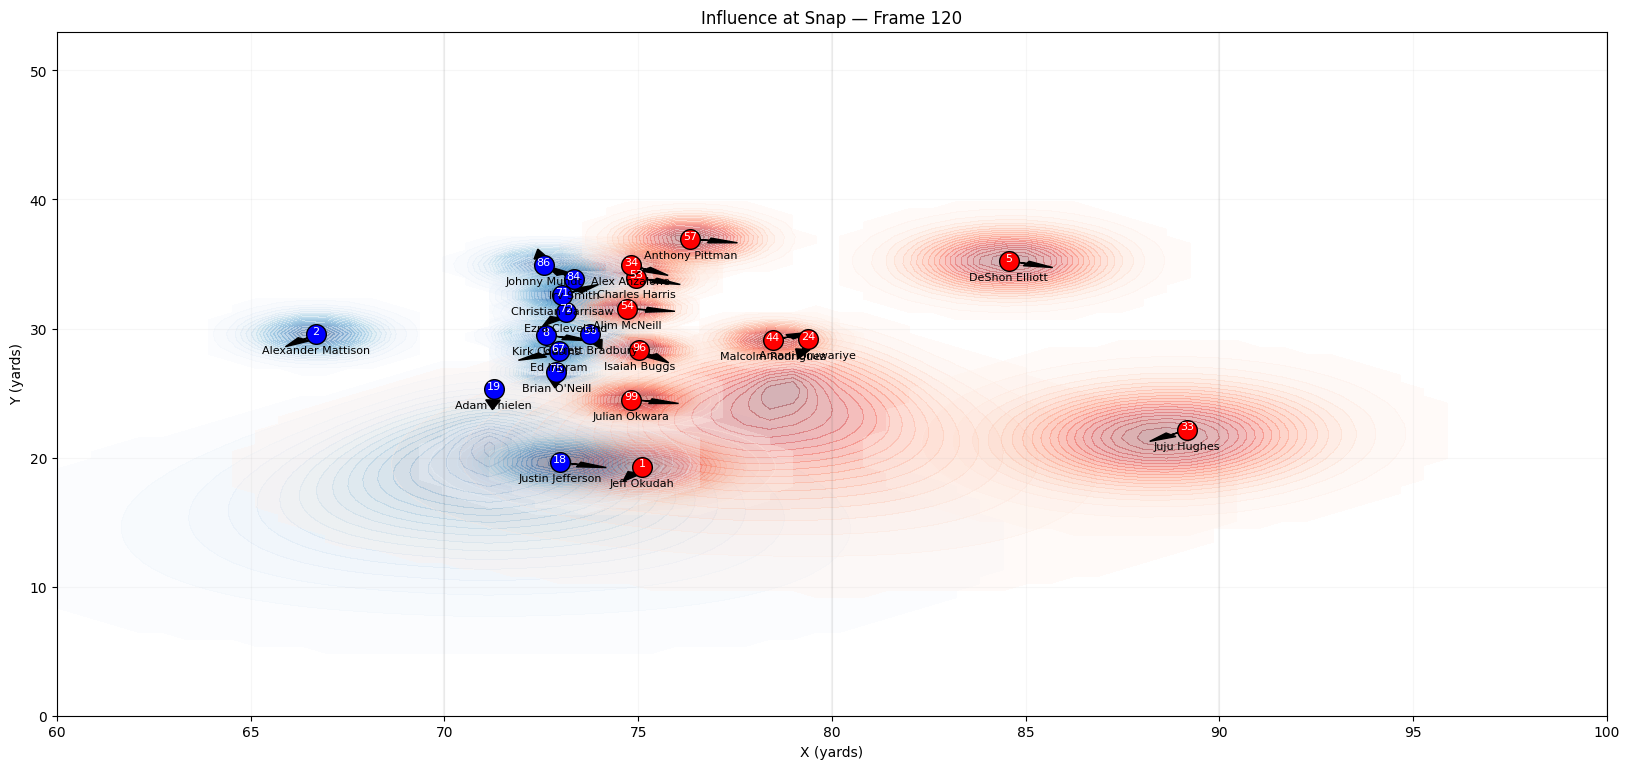

(<Figure size 2000x888.333 with 1 Axes>,
 <Axes: title={'center': 'Influence at Snap — Frame 120'}, xlabel='X (yards)', ylabel='Y (yards)'>)

In [ ]:

# 3) Plot (no need to pass orientation_bias_deg—plotter uses per-row stored bias)
plot_player_densities_from_dataframe(
    all_player_df,
    grid,
    frame_id=frame_to_plot,
    contour_levels=20,
    contour_alpha=0.3,
    off_cmap="Reds",
    on_cmap="Blues",
    arrow_scale=0.5,
    xlim=(60, 100),
    ylim=(0, 53),
    title="Influence at Snap",
)

In [ ]:

class AnimatePlayWithDensity:
    def __init__(
        self,
        play_df,
        precomputed_df,
        grid,
        plot_size_len=16,
        *,
        # contours
        show_contours=True,
        contour_levels=20,
        contour_alpha=0.30,
        off_cmap="Reds",
        on_cmap="Blues",
        # arrows
        arrow_scale=2.0,             # base arrow length in yards, will be modestly scaled by speed
        arrow_head_width=0.375,
        arrow_head_length=0.75,
        # orientation fallback (used only if theta_rad is not stored in precomputed_df)
        orientation_bias_deg=90.0,    # << your class now uses +90 (not -90)
        # view
        xlim=None, ylim=None, grid_alpha=0.10,
        title="Play Animation with Influence"
    ) -> None:
        """
        Animate a play with precomputed densities (from PlayerInfluenceModelTunable).

        - `precomputed_df` should be the output of `compute_player_densities_dataframe`
           that includes columns: frameId, nflId, x, y, speed, is_off, density,
           and ideally theta_rad (exact heading used by the model) + orientation_bias_deg.
        - If theta_rad is present, arrows use it directly; otherwise they fall back to
          the same orientation convention your class uses (double-correct + bias).
        """
        # constants
        self._MAX_FIELD_Y = 53.3
        self._MAX_FIELD_X = 120
        self._MAX_FIELD_PLAYERS = 22  # max players to pre-allocate text/arrow artists

        # data
        self._frame_data = play_df
        self._precomputed_df = precomputed_df
        self._X, self._Y = grid
        self._frames = sorted(play_df.frameId.unique())

        # style / options
        self.show_contours = show_contours
        self.contour_levels = contour_levels
        self.contour_alpha = contour_alpha
        self.off_cmap = off_cmap
        self.on_cmap = on_cmap

        self.arrow_scale = arrow_scale
        self.arrow_head_width = arrow_head_width
        self.arrow_head_length = arrow_head_length

        self.orientation_bias_deg = orientation_bias_deg  # fallback only
        self.xlim = xlim
        self.ylim = ylim
        self.grid_alpha = grid_alpha
        self._title = title

        # stream
        self._stream = self.data_stream()

        # fig/axes
        aspect = self._MAX_FIELD_Y / self._MAX_FIELD_X
        self._fig = plt.figure(figsize=(plot_size_len, plot_size_len * aspect))
        self._ax_field = plt.gca()

        # storage for artists
        self._scat_jersey_list = []
        self._scat_number_list = []
        self._scat_name_list = []
        self._a_dir_list = []
        self._a_or_list = []
        self._contours = []

        # start animation
        self.ani = animation.FuncAnimation(
            self._fig, self.update, frames=len(self._frames),
            init_func=self.setup_plot, blit=False
        )
        plt.close()

    # ---------- orientation helpers (fallback only if theta_rad missing) ----------
    @staticmethod
    def _norm(a): return (a + 360.0) % 360.0
    def _corrected(self, deg): return self._norm(90.0 - deg)
    def _double_corrected(self, deg): return self._corrected(self._corrected(deg))
    def _theta_fallback(self, dir_deg):
        # radians: (double-corrected) + global bias
        return np.radians(self._norm(self._double_corrected(dir_deg) + self.orientation_bias_deg))

    # ---------- plumbing ----------
    @staticmethod
    def set_axis_plots(ax, max_x, max_y) -> None:
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        ax.set_xlim([0, max_x])
        ax.set_ylim([0, max_y])

    def data_stream(self):
        for frame in self._frames:
            yield self._frame_data[self._frame_data.frameId == frame]

    def setup_plot(self):
        # Field setup
        self.set_axis_plots(self._ax_field, self._MAX_FIELD_X, self._MAX_FIELD_Y)
        for idx in range(10, 120, 10):
            self._ax_field.axvline(idx, color='k', linestyle='-', alpha=0.05)

        # Initial scatters
        self._scat_ball = self._ax_field.scatter([], [], s=100, color='black', label="Football")
        self._scat_offense = self._ax_field.scatter([], [], s=500, color='blue', edgecolors='k', label="Offense")
        self._scat_defense = self._ax_field.scatter([], [], s=500, color='red', edgecolors='k', label="Defense")

        # Pre-allocate text + arrows (so we can update in-place)
        for _ in range(self._MAX_FIELD_PLAYERS):
            self._scat_jersey_list.append(self._ax_field.text(0, 0, '', ha='center', va='center', c='white'))
            self._scat_number_list.append(self._ax_field.text(0, 0, '', ha='center', va='center', c='black'))
            self._scat_name_list.append(self._ax_field.text(0, 0, '', ha='center', va='center', c='black'))
            self._a_dir_list.append(self._ax_field.add_patch(Arrow(0, 0, 0, 0, color='k')))
            self._a_or_list.append(self._ax_field.add_patch(Arrow(0, 0, 0, 0, color='grey', width=2)))

        # Title & view
        self._ax_field.set_title(self._title)
        if self.xlim: self._ax_field.set_xlim(*self.xlim)
        if self.ylim: self._ax_field.set_ylim(*self.ylim)
        self._ax_field.grid(alpha=self.grid_alpha)

        return (self._scat_ball, self._scat_offense, self._scat_defense, *self._scat_jersey_list)

    def clear_contours_safe(self, contours_list):
        """
        Safely clear matplotlib contours across different versions
        """
        for contour in contours_list:
            try:
                # Try the most common approaches
                if hasattr(contour, 'collections'):
                    # Newer matplotlib
                    for collection in contour.collections:
                        collection.remove()
                elif hasattr(contour, 'remove'):
                    # Direct removal
                    contour.remove()
                else:
                    # Try iterating (some contour objects are iterable)
                    for artist in contour:
                        if hasattr(artist, 'remove'):
                            artist.remove()
            except (TypeError, AttributeError, ValueError):
                # Skip problematic contours
                continue

        contours_list.clear()

    def update(self, _frame_index):
        # grab next frame of positional data
        pos_df = next(self._stream)
        frame_id = int(pos_df.frameId.iloc[0])

        # split
        offense_df = pos_df[pos_df.is_off == 1]
        defense_df = pos_df[pos_df.is_off == 0]
        ball_df    = pos_df[pos_df.team == 'football'] if 'team' in pos_df.columns \
                     else pos_df[pos_df.displayName.str.lower() == 'football']

        # update scatters
        if not offense_df.empty:
            self._scat_offense.set_offsets(np.vstack([offense_df.x, offense_df.y]).T)
        if not defense_df.empty:
            self._scat_defense.set_offsets(np.vstack([defense_df.x, defense_df.y]).T)
        if not ball_df.empty:
            self._scat_ball.set_offsets(np.vstack([ball_df.x, ball_df.y]).T)

        self._ax_field.set_title(f"{self._title} — Frame {frame_id}")

        # clear old contours - FIXED VERSION
        self.clear_contours_safe(self._contours)

        # plot densities for this frame
        if self.show_contours:
            frame_density_df = self._precomputed_df[self._precomputed_df.frameId == frame_id]
            for _, prow in frame_density_df.iterrows():
                Z = prow['density']
                if Z is None:
                    continue
                cmap = self.on_cmap if prow.get('is_off', 0) == 1 else self.off_cmap
                Z_masked = np.where(Z > 0.01, Z, np.nan)
                cont = self._ax_field.contourf(self._X, self._Y, Z_masked,
                                               cmap=cmap, levels=self.contour_levels, alpha=self.contour_alpha)
                self._contours.append(cont)

        # update per-player labels + arrows
        labeled = pos_df[pos_df.jerseyNumber.notnull()].reset_index(drop=True)
        for idx in range(min(len(labeled), self._MAX_FIELD_PLAYERS)):
            row = labeled.iloc[idx]
            x0, y0 = row.x, row.y

            # jersey/number/name
            self._scat_jersey_list[idx].set_position((x0, y0))
            self._scat_jersey_list[idx].set_text(row.position if 'position' in row else '')
            self._scat_number_list[idx].set_position((x0, y0 + 1.5))
            try:
                jn = int(row.jerseyNumber)
                self._scat_number_list[idx].set_text(jn)
            except Exception:
                self._scat_number_list[idx].set_text('')
            self._scat_name_list[idx].set_position((x0, y0 - 1.5))
            name = row.displayName.split()[-1] if isinstance(row.displayName, str) else ''
            self._scat_name_list[idx].set_text(name)

            # heading for arrows
            # Prefer theta_rad stored in precomputed_df for this player+frame
            theta_rad = None
            match = self._precomputed_df[
                (self._precomputed_df.frameId == frame_id) & (self._precomputed_df.nflId == row.nflId)
            ]
            if not match.empty:
                theta_rad = match.iloc[0].get('theta_rad', None)

            if theta_rad is None:
                # fallback to same convention the model uses: double-correct + +90 bias
                theta_rad = self._theta_fallback(row.dir)

            # direction arrow length (modest speed scaling)
            spd = float(row.s) if 's' in row else 0.0
            L = self.arrow_scale * (1.0 + min(max(spd, 0.0), 11.3) / 11.3)

            # "direction" (black) arrow
            self._a_dir_list[idx].remove()
            self._a_dir_list[idx] = self._ax_field.add_patch(
                Arrow(x0, y0, L*np.cos(theta_rad), L*np.sin(theta_rad),
                      color='k', width=0.0, alpha=1.0)
            )

            # "orientation" (grey) arrow — optional (uses row.o if present)
            orient_theta = None
            if 'o' in row and not np.isnan(row.o):
                # orientation often differs from 'dir'; draw shorter, in grey
                orient_theta = self._theta_fallback(row.o)
            self._a_or_list[idx].remove()
            if orient_theta is not None:
                self._a_or_list[idx] = self._ax_field.add_patch(
                    Arrow(x0, y0, (L*0.6)*np.cos(orient_theta), (L*0.6)*np.sin(orient_theta),
                          color='grey', width=2, alpha=0.9)
                )
            else:
                self._a_or_list[idx] = self._ax_field.add_patch(Arrow(0,0,0,0,color='grey',width=0))

        return (self._scat_ball, self._scat_offense, self._scat_defense, *self._scat_jersey_list)

In [ ]:
# precompute (stores theta_rad + orientation_bias_deg per row)
all_player_df, grid = compute_player_densities_dataframe(
    df,
    min_frame=1, max_frame=200,
    model_kwargs={"orientation_bias_deg": 90.0},  # << your fixed class bias
    sigma_gaussian=5, alpha_gamma=11
)

# subset your tracking data to the same play/frames
play_df = df[(df["frameId"] >= 1) & (df["frameId"] <= 200)].copy()

# animate
anim = AnimatePlayWithDensity(
    play_df=play_df,
    precomputed_df=all_player_df,
    grid=grid,
    plot_size_len=16,
    show_contours=True,
    contour_levels=20,
    contour_alpha=0.3,
    on_cmap="Blues",
    off_cmap="Reds",
    arrow_scale=1.5,
    orientation_bias_deg=0,  # only used as fallback if theta_rad missing
    xlim=(60, 100), ylim=(10, 40),
    title="Influence Over Time"
)

anim.ani.save("play_with_densities_test.mp4", fps=10)
files.download("play_with_densities_test.mp4")

plt.show()

/tmp/ipython-input-4205020669.py:131: RuntimeWarning: divide by zero encountered in divide
  H[mask] *= np.exp(-((d_proj[mask] - self.max_forward_distance) ** 2) / (2 * (speed * fade) ** 2))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:


def compute_player_densities_with_pitch_control(
    model,
    df,
    frame_id,
    *,
    grid=None,                          # (X, Y) tuple; if None, uses model.grid or builds default
    smooth_sigma=2.0,                   # gaussian smoothing for influence maps
    pitch_k=25.0,                       # sigmoid steepness for pitch control
    neutral_band=(0.45, 0.55),          # mask band for "neutral" areas
    use_cached_density=True,            # use 'density' column if available
    cache_back_to_df=False              # if computed, store density back onto df for reuse
):
    """
    Compute offense/defense influence and pitch control for a single frame using a tunable model.

    Parameters
    ----------
    model : PlayerInfluenceModelTunable-like
        Expected to expose either:
          - a batch method: `compute_densities(frame_df, X, Y) -> np.ndarray[n_players, Y, X]`
        or per-row method:
          - `compute_density(row, X, Y) -> np.ndarray[Y, X]`
        Optionally may expose `model.grid` as a (X, Y) meshgrid.
    df : pandas.DataFrame
        Tracking-like frame data with at least:
          ['frameId','displayName','nflId','jerseyNumber','x','y','speed','direction','is_off']
        If `use_cached_density=True`, can include a 'density' column (array-like per row).
    frame_id : int
        Frame to compute.
    grid : tuple(np.ndarray, np.ndarray) or None
        Meshgrid (X, Y). If None, use `model.grid` if present, otherwise default to 120x53.3.
    smooth_sigma : float
        Sigma passed to `scipy.ndimage.gaussian_filter` for smoothing influence maps.
    pitch_k : float
        Steepness for the sigmoid that maps influence diff -> [0,1] control.
    neutral_band : (float, float)
        Inclusive band to mask out near-50/50 regions.
    use_cached_density : bool
        If True and a 'density' column exists, use it.
    cache_back_to_df : bool
        If True and densities are computed via the model, write them back to a 'density' column.

    Returns
    -------
    player_df : pd.DataFrame
        Per-player influence summaries (includes 'density' and 'sum_density').
    offense_influence_df : pd.DataFrame
        Smoothed offensive influence grid (indexed by y, columns by x).
    defense_influence_df : pd.DataFrame
        Smoothed defensive influence grid (indexed by y, columns by x).
    pitch_control_df : pd.DataFrame
        Pitch control grid (masked in neutral_band).
    """

    # --- grid setup ----------------------------------------------------------
    if grid is not None:
        X, Y = grid
    elif hasattr(model, "grid") and model.grid is not None:
        X, Y = model.grid
    else:
        x_vals = np.linspace(0.0, 120.0, 200)
        y_vals = np.linspace(0.0, 53.3, 100)
        X, Y = np.meshgrid(x_vals, y_vals)

    x_vals = X[0, :]
    y_vals = Y[:, 0]

    # --- helpers -------------------------------------------------------------
    def _sigmoid(z, k):
        return 1.0 / (1.0 + np.exp(-k * z))

    # --- frame slice ---------------------------------------------------------
    frame_df = df[df["frameId"] == frame_id]
    if frame_df.empty:
        raise ValueError(f"No data found for frame {frame_id}.")

    # Exclude ball / invalid rows up front
    frame_df = frame_df.loc[
        (frame_df["displayName"].str.lower() != "football")
        & (~frame_df["is_off"].isna())
    ].copy()

    # --- density acquisition -------------------------------------------------
    # Try batch path first if available and not using cache:
    densities = None
    can_batch = hasattr(model, "compute_densities")

    if use_cached_density and "density" in frame_df.columns and frame_df["density"].notna().all():
        # Use cached densities
        densities = np.stack(frame_df["density"].to_numpy(), axis=0)
    else:
        if can_batch:
            densities = model.compute_densities(frame_df, X, Y)  # expected shape: (n_players, Y, X)
            if cache_back_to_df:
                frame_df.loc[:, "density"] = list(densities)
        else:
            # Row-by-row fallback
            dens_list = []
            for _, row in frame_df.iterrows():
                d = model.compute_density(row, X, Y)  # expected shape: (Y, X)
                dens_list.append(d)
            densities = np.stack(dens_list, axis=0)
            if cache_back_to_df:
                frame_df.loc[:, "density"] = dens_list

    # --- threshold tiny values to remove speckle -----------------------------
    densities = np.where(densities < 1e-3, 0.0, densities)

    # --- split & accumulate offense/defense ---------------------------------
    is_off_mask = frame_df["is_off"].to_numpy().astype(bool)
    inf_offense = densities[is_off_mask].sum(axis=0) if is_off_mask.any() else np.zeros_like(X)
    inf_defense = densities[~is_off_mask].sum(axis=0) if (~is_off_mask).any() else np.zeros_like(X)

    # --- normalize to [0,1] before smoothing (guards against blowups) -------
    def _safe_norm(A):
        mx = A.max()
        return A / mx if mx > 0 else A

    inf_offense = _safe_norm(inf_offense)
    inf_defense = _safe_norm(inf_defense)

    # --- smooth to reduce artifacts -----------------------------------------
    if smooth_sigma and smooth_sigma > 0:
        inf_offense = gaussian_filter(inf_offense, sigma=smooth_sigma)
        inf_defense = gaussian_filter(inf_defense, sigma=smooth_sigma)

    # --- pitch control -------------------------------------------------------
    # convention: higher value -> defense control; invert if you want offense
    pitch_control = _sigmoid(inf_defense - inf_offense, k=pitch_k)

    # mask near-50/50 band
    lo, hi = neutral_band
    mask = (pitch_control >= lo) & (pitch_control <= hi)
    pitch_control_masked = np.where(mask, np.nan, pitch_control)

    # --- per-player summary table -------------------------------------------
    sum_density = densities.reshape(densities.shape[0], -1).sum(axis=1)
    player_df = frame_df.assign(
        frameId=frame_id,
        sum_density=sum_density,
    ).copy()

    # Keep a consistent column order if you like:
    keep_cols = [
        "frameId", "nflId", "displayName", "jerseyNumber",
        "x", "y", "direction", "speed", "is_off", "density", "sum_density"
    ]
    player_df = player_df[[c for c in keep_cols if c in player_df.columns]]

    # --- grid -> DataFrames --------------------------------------------------
    offense_influence_df = pd.DataFrame(inf_offense, index=y_vals, columns=x_vals)
    defense_influence_df = pd.DataFrame(inf_defense, index=y_vals, columns=x_vals)
    pitch_control_df   = pd.DataFrame(pitch_control_masked, index=y_vals, columns=x_vals)

    return player_df, offense_influence_df, defense_influence_df, pitch_control_df


In [ ]:
def visualize_pitch_control_with_players(pitch_control_df, player_df, frame_id):
    """
    Visualize the pitch control grid for a single frame with player positions, jersey numbers,
    player names, and directional arrows based on speed and orientation.
    """
    def corrected_orientation(original_orientation):
        """Correct orientation: 0° is North, 90° is East."""
        return (90 - original_orientation) % 360

    plt.figure(figsize=(12, 6))
    plt.title(f"Team Field Control - At Snap")

    # Plot pitch control
    plt.contourf(pitch_control_df.columns, pitch_control_df.index, pitch_control_df,
                 cmap='coolwarm', levels=20, alpha=0.8)
    plt.colorbar(label="Field Control")

    # Plot player positions and details
    for _, row in player_df[player_df['frameId'] == frame_id].iterrows():
        color = 'blue' if row.is_off else 'red'  # Offensive (red) or defensive (blue)
        player_pos = (row.x, row.y)

        # Plot player position
        plt.scatter(player_pos[0], player_pos[1], color=color, edgecolor='black', s=100, zorder=5)

        # Add player jersey number and name
        if pd.notna(row['jerseyNumber']):
            plt.text(player_pos[0], player_pos[1] + 1, f"{int(row['jerseyNumber'])}",
                     fontsize=10, ha='center', color='black', zorder=6)
        if pd.notna(row['displayName']):
            plt.text(player_pos[0], player_pos[1] - 1.5, row['displayName'],
                     fontsize=8, ha='center', color='black', zorder=6)

        # Add directional arrow based on orientation and speed
        if pd.notna(row['direction']) and pd.notna(row['speed']):
            theta = np.radians(corrected_orientation(row['direction']))
            arrow_length = row['speed'] / 11.3 * 5  # Normalize arrow length
            plt.arrow(player_pos[0], player_pos[1],
                      arrow_length * np.cos(theta),
                      arrow_length * np.sin(theta),
                      head_width=.375, head_length=.75, fc='black', ec='black', zorder=2)
    plt.xlim(60,110)
    plt.ylim(5,45)
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.grid(alpha=0.5)
    plt.show()


/tmp/ipython-input-4205020669.py:131: RuntimeWarning: divide by zero encountered in divide
  H[mask] *= np.exp(-((d_proj[mask] - self.max_forward_distance) ** 2) / (2 * (speed * fade) ** 2))


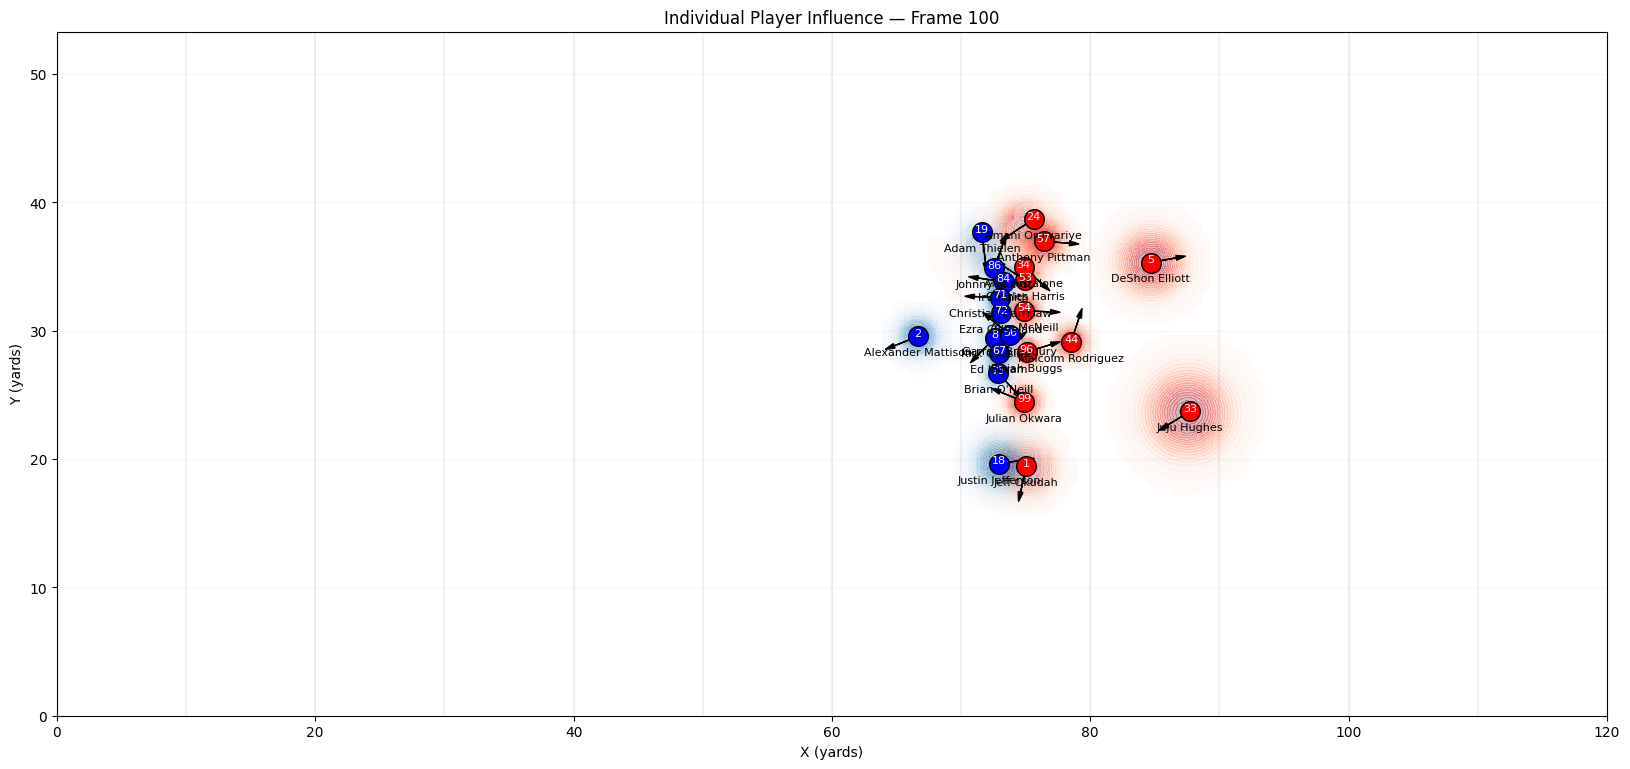

(<Figure size 2000x888.333 with 1 Axes>,
 <Axes: title={'center': 'Individual Player Influence — Frame 100'}, xlabel='X (yards)', ylabel='Y (yards)'>)

In [ ]:
# Step 2: Plot the densities using the stored density grids
frame_id=100
player_df, grid = compute_player_densities_dataframe(df,min_frame=100, max_frame=100)
plot_player_densities_from_dataframe(player_df, grid, frame_id)

In [ ]:
player_df

,frameId,nflId,displayName,jerseyNumber,x,y,speed,direction,is_off,dist_from_football,orientation_bias_deg,density
0,100,38632.0,Kirk Cousins,8.0,72.62,29.463333,0.01,135.89,1.0,1.460858,90.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,100,40488.0,Adam Thielen,19.0,71.62,37.663333,2.25,186.56,1.0,8.513172,90.0,"[[1.583516204252458e-16, 1.3359949278482576e-1..."
2,100,44834.0,Charles Harris,53.0,74.97,33.923333,0.02,56.51,0.0,4.498910,90.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,100,44888.0,Alex Anzalone,34.0,74.84,34.943333,0.02,227.92,0.0,5.482927,90.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,100,45094.0,Johnny Mundt,86.0,72.54,34.883333,0.01,339.48,1.0,5.586457,90.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
5,100,46131.0,Brian O'Neill,75.0,72.89,26.693333,0.00,222.08,1.0,3.060802,90.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
6,100,46259.0,DeShon Elliott,5.0,84.68,35.313333,0.05,280.43,0.0,12.083044,90.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
7,100,47801.0,Garrett Bradbury,56.0,73.78,29.663333,0.01,49.80,1.0,0.335412,90.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
8,100,47833.0,Irv Smith,84.0,73.30,33.833333,0.00,82.20,1.0,4.389852,90.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
9,100,47885.0,Alexander Mattison,2.0,66.68,29.563333,0.00,111.75,1.0,7.400171,90.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


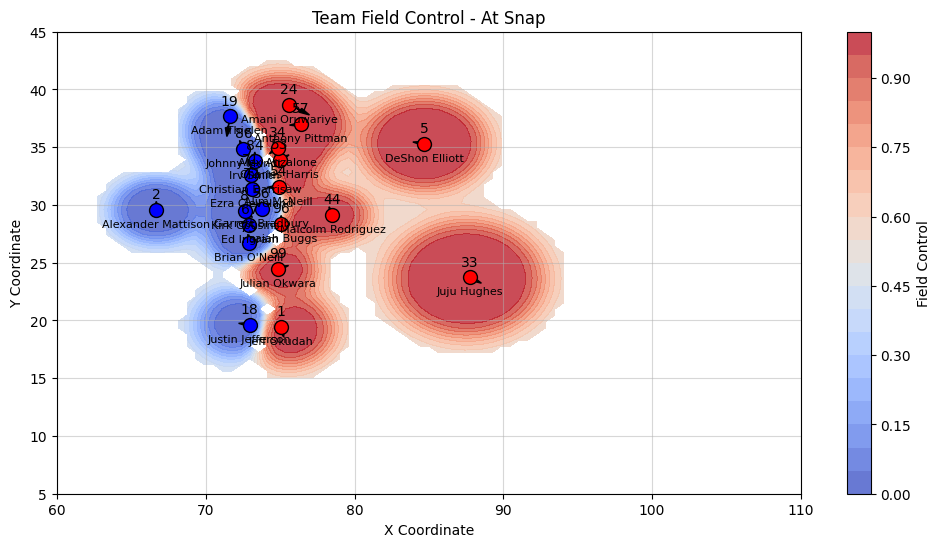

In [ ]:
# 1) Make sure densities are numpy arrays and consistent shape
player_df["density"] = player_df["density"].apply(lambda d: np.asarray(d, dtype=float))
ny, nx = player_df["density"].iloc[0].shape  # e.g., (100, 200)

# 2) Build a grid that matches those shapes
x_vals = np.linspace(0.0, 120.0, nx)
y_vals = np.linspace(0.0, 53.3, ny)
X, Y = np.meshgrid(x_vals, y_vals)

# 3) Compute pitch control using cached densities (no model)
player_df2, offense_df, defense_df, pitch_control_df = compute_player_densities_with_pitch_control(
    model=None,
    df=player_df,
    frame_id=100,
    grid=(X, Y),
    use_cached_density=True,
    cache_back_to_df=False
)

# 4) Visualize
visualize_pitch_control_with_players(pitch_control_df, player_df2, frame_id=100)
